# Unattended Bag Detection

### Overview of Project

#### Guidelines for preprocessing data
1. (Most Important):Split into 4 labels: 
    1. person 
    2. handbag 
    3. backpack 
    4. luggage
<br></br>
2. Standardize removing the extension name in the xml annotation file (if present) and standardize/renaming all the image(s) to '.jpg' image extension
<br></br>    
3. Convert all images to 640 x 640 x 3 by resizing/pad (maintain same aspect ratio) and its corresponding XML annotations (size, bndbox)
<br></br>
4. Images that contain more than one class (e.g. both a person and a backpack) must have all the classes in it annotated to form a valid data point.   
    - If there is no annotation for a class, we will use a trained model to detect the class and create bbox

### Data Preprocessing for ImageNet Bags

 Folder directory outline
 - Filtered
    - annotations
      - backpack
      - n03709823
      - n04026417
    - images
      - backpack
      - n03709823
      - n04026417  
 - Unfiltered
   - annotations
   - images
<br></br>

- Unfiltered folder contains the raw data while Filtered folder contains the processed data

<a id='toc'></a>
### Table of Contents
- <a href='#examineunfiltered'>Data Exploration: Examining unfiltered data </a>
   -  <a href='#count'>Count of files from specified folder [folder_info()]</a>
   - <a href='#imgmissingannot'>Finding images with missing annotations </a>
   - <a href='#vis_image_missing_annot'>Visualising image from a provided list of images with missing annotation [visualise_from_list()]</a>


   -  <a href='#uniqxml'>Getting unique xml names in file</a>
   - <a href='#replace'>Replacing folder name </a>
   - <a href='#countimg'>Count different image file extension from specified image folder</a>
   - <a href='#countxml'> Count different image file extension in the filename of the xml annotation</a>
<br> </br>
- <a href='#Filtering'>Filtering Process</a>
   - Mapping to Appropriate class
      - <a href=#map>Map Object Names into the appropriate classes</a>
      - <a href=#copyimgfolder>Copy images folder with mapping information</a>
   - Standardize extension format
      - <a href='#converttojpg'>Convert all images' file extension in images folder to '.jpg</a>
      - <a href='#remove_ext_xml'>Removing extension name in XML annotation</a>
<br> </br>
- <a href='#examinefiltered'>Examining Filtered data</a>
   - <a href='#visualmisclassified'>Visually inspecting for misclassified class</a>
      - backpack class
<br> </br>
- <a href='#convertimgsize'>Converting image size and corresponding XML annotations </a>
   - <a href='#convertxml'>Converting XML annotations</a>
   - <a href='#convertimg'>Converting image file</a>
<br> </br>
- <a href='#visualimgbbox'>Visualising image and bounding box</a>
<br> </br>
- <a href='#model_generate_annot'>Using trained model to generate missing annotations</a>



<a id='examineunfiltered'></a>
## Data Exploration: Examining unfiltered data

<a id='count'></a>
### Count of files from specified folder (folder_info())
 #### <a href='#toc'>^ Back to Table of Contents</a>

In [1]:
### getting count of files from specified folder 
import os
from pathlib import Path

def file_info(dir):
    ''' Return list of files and count of files
    '''
    files=os.listdir(dir)
    count=len(os.listdir(dir))
    return files,count

def folder_info(folder_name):
    '''
    Go the subfolders in specified folder and print count of files in each subfolder
    '''
    for i in os.listdir(folder_name):
        folder_p=Path(os.path.join(folder_name,i))

        for folder in folder_p.iterdir():
            count=file_info(folder)[1]
            print(f'Folder {folder}: {count} files')
    return


In [2]:
folder_info('Unfiltered')

Folder Unfiltered\annotations\bag: 618 files
Folder Unfiltered\annotations\n03709823: 433 files
Folder Unfiltered\annotations\n04026417: 522 files
Folder Unfiltered\images\bag: 618 files
Folder Unfiltered\images\n03709823: 1300 files
Folder Unfiltered\images\n04026417: 1300 files


<a id='imgmissingannot'></a>
## Finding images with missing annotations
 #### <a href='#toc'>^ Back to Table of Contents</a>

In [3]:
import os

def get_files_names_with_extension(full_path, format):
    ''' Function returns all files for the paricular format
    '''
    if format=='image':
        exts=('.JPEG','jpeg','.jpg','.tif','.tiff','.bmp','.gif','.png','.raw')
    elif format=='xml':
        exts='xml'
    else:
        raise Exception('Please input either "image" or "xml" for format argument')
    
    return [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f)) and f.endswith(exts)]


def find_images_with_missing_annot(folder_img,folder_annot):
    subfolders=os.listdir(folder_annot)
    missing_annot_dict={}
    
    for subfolder in subfolders:
        missing_annot_dict[subfolder]=set()
        path_to_subfolder_img=os.path.join(folder_img,subfolder)
        path_to_subfolder_annot=os.path.join(folder_annot,subfolder)
        images =  set([f.split('.')[0] for f in get_files_names_with_extension(path_to_subfolder_img,format='image')])
        annotations = set([f.split(".")[0] for f in get_files_names_with_extension(path_to_subfolder_annot, "xml")])
        diff=images.difference(annotations)
        missing_annot_dict[subfolder]=diff
    
    return missing_annot_dict


In [4]:
folder_img = r"Unfiltered\images"
folder_annot =r"Unfiltered\annotations"
folder_missing_annot=find_images_with_missing_annot(folder_img,folder_annot)


for folder,missing_annot_set in folder_missing_annot.items():
    print (f'Folder {folder} has {len(missing_annot_set)} images with missing annotations')

print(folder_missing_annot)

Folder bag has 0 images with missing annotations
Folder n03709823 has 867 images with missing annotations
Folder n04026417 has 778 images with missing annotations
{'bag': set(), 'n03709823': {'n03709823_8931', 'n03709823_11657', 'n03709823_17190', 'n03709823_13861', 'n03709823_18302', 'n03709823_13887', 'n03709823_12917', 'n03709823_25081', 'n03709823_17660', 'n03709823_12932', 'n03709823_12765', 'n03709823_16838', 'n03709823_7753', 'n03709823_12571', 'n03709823_19646', 'n03709823_4432', 'n03709823_16989', 'n03709823_26430', 'n03709823_11262', 'n03709823_6369', 'n03709823_1079', 'n03709823_27969', 'n03709823_11516', 'n03709823_18314', 'n03709823_11527', 'n03709823_1530', 'n03709823_23615', 'n03709823_15550', 'n03709823_21615', 'n03709823_16130', 'n03709823_16137', 'n03709823_18323', 'n03709823_9816', 'n03709823_12140', 'n03709823_27907', 'n03709823_15093', 'n03709823_11873', 'n03709823_8527', 'n03709823_6873', 'n03709823_31632', 'n03709823_18485', 'n03709823_26340', 'n03709823_24105', 

<a id='vis_image_missing_annot'></a>
## Visualising image from a provided list of images with missing annotations
#### <a href='#toc'>^ Back to Table of Contents</a>

In [5]:
#### Visualising image from a provided list of images with missing annotations
import matplotlib.pyplot as plt
from random import sample

def visualise_from_list(folder_img,visualised_list,ext,sample_size):
    if sample_size:
        visualised_list=sample(visualised_list,sample_size)
    for image_filename in visualised_list:
        image_filename=f'{image_filename}.{ext}'
        image_array=plt.imread(os.path.join(folder_img,image_filename))
        _,ax=plt.subplots()
        axes_image=ax.imshow(image_array)
    
    return axes_image

C:\Users\mpe_0\miniconda3\envs\torch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mpe_0\miniconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\mpe_0\miniconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


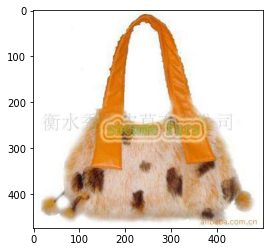

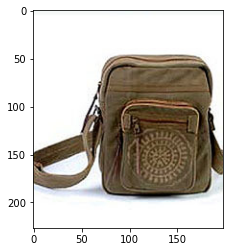

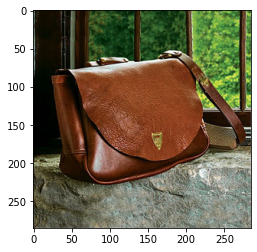

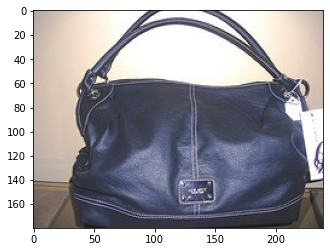

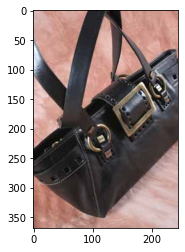

In [6]:
##visualising images with missing annotations (by sampling 5 from the list)
folder_img = "Unfiltered/images"
folder_annot ="Unfiltered/annotations"

filtered_missing_annot=find_images_with_missing_annot(folder_img,folder_annot)
visualised_list=list(filtered_missing_annot['n03709823'])

path=os.path.relpath('Unfiltered/images/n03709823')

visualise_from_list(path,visualised_list,ext='JPEG',sample_size=10)

<a id='uniqxml'></a>
### Getting unique xml names in file

 #### <a href='#toc'>^ Back to Table of Contents</a>

In [7]:
## Getting unique xml names in file
import xml.etree.ElementTree as ElementTree
import os
def get_object(root):
    return root.findall('./object')

def get_name(object):
    for name in object.findall('./name'):
        return name.text


def unique_xml_names_in_annot_folder(folder_annot):
    # get all subfolders in main folder
    subfolders=os.listdir(folder_annot)
    uniq_xmlnames_in_folders={}
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(folder_annot,subfolder)
        # initalised empty set in dictionary
        uniq_xmlnames_in_folders[subfolder]=set()
        for xml_annotation in os.listdir(path_to_subfolder):
            file=os.path.join(path_to_subfolder,xml_annotation)
            tree=ElementTree.parse(file)
            root=tree.getroot()           
            for object in get_object(root):
                name=get_name(object)
                uniq_xmlnames_in_folders[subfolder].add(name)
    
    return uniq_xmlnames_in_folders

In [8]:
unique_xml_names_in_annot_folder('Unfiltered/annotations')

{'bag': {'bag'}, 'n03709823': {'n03709823'}, 'n04026417': {'n04026417'}}

<a id='replace'></a>
### Replacing folder name
- The folder name 'backpack' shall be renamed as 'bag' since for all the xml annotations in folder 'backpack' ,the object name is actually 'bag'
#### <a href='#toc'>^ Back to Table of Contents</a>

In [9]:
rename_folder={'backpack':'bag'}

folder_name='Unfiltered'
for i in os.listdir(folder_name):
    folder_p=Path(os.path.join(folder_name,i))

    for folder in os.listdir(folder_p):
        if folder in rename_folder:
            curr_path=os.path.join(folder_p,folder)
            rename_path=os.path.join(folder_p,rename_folder[folder])
            os.rename(curr_path,rename_path)
            print(f'{curr_path} has been renamed to {rename_path}')
                

<a id='countimg'></a>
## Count different image file extension from image folder
 #### <a href='#toc'>^ Back to Table of Contents</a>

In [10]:
### get images file extension
def count_img_ext(folder_img):
    subfolders=os.listdir(folder_img)
    img_ext_dict={}
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(folder_img,subfolder)
        # initalised empty nested dictionary in dictionary if the folder name does not exist
        img_ext_dict[subfolder]=dict()
        for image in os.listdir(path_to_subfolder):
            # get the file extension by getting 2nd element
            img_ext=image.split('.')[1]
            if img_ext not in img_ext_dict[subfolder]:
                img_ext_dict[subfolder][img_ext]=0
            img_ext_dict[subfolder][img_ext]+=1
    return img_ext_dict

In [11]:
specified_folder='Unfiltered/images' 
count_img_ext(specified_folder)

{'bag': {'jpg': 618}, 'n03709823': {'JPEG': 1300}, 'n04026417': {'JPEG': 1300}}

<a id='countxml'></a>
## Count different image file extension in the filename of the xml annotation
 #### <a href='#toc'>^ Back to Table of Contents</a>

In [12]:
import xml.etree.ElementTree as ElementTree
import os
import numpy as np

def get_image_filename(root):
    return root.find('filename').text

def count_xml_ext(folder_annot):
    subfolders=os.listdir(folder_annot)
    xml_ext_dict=dict()
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(folder_annot,subfolder)
        xml_ext_dict[subfolder]=dict()
        for xml_annotation in os.listdir(path_to_subfolder):
            file=os.path.join(path_to_subfolder,xml_annotation)
            tree=ElementTree.parse(file)
            root=tree.getroot()
            image=get_image_filename(root)
            # if there is a dot, means there is a extension name
            
            if '.' in image:
                xml_ext=image.split('.')[1]
                if xml_ext not in xml_ext_dict[subfolder]:
                    xml_ext_dict[subfolder][xml_ext]=0
                xml_ext_dict[subfolder][xml_ext]+=1
    
    return xml_ext_dict
         

In [13]:
specified_folder='Unfiltered/annotations' 
count_xml_ext(specified_folder)

{'bag': {'jpg': 618}, 'n03709823': {}, 'n04026417': {}}

<a id='Filtering'></a>
## Filtering Process
 #### <a href='#toc'>^ Back to Table of Contents</a>


<a id=map></a>
## Map Object Names into the appropriate classes
 #### <a href='#toc'>^ Back to Table of Contents</a>
### Background
- ImageNet there are 3 types: 
    - n04026417(purses): Mapped to handbag
    - n03709823 (mailbag): Mapped to handbag
    - bag: Mapped to backpack
- Reason on the need to subclassify the bags is so that do not inadvertently force the model to recognise different looking types of bag and fit them into a classifcation as bag. Also, if there are more classes, the model will tend to learn more things

### Functions used
-   [Modifying an XML file](https://docs.python.org/2/library/xml.etree.elementtree.html#modifying-an-xml-file) 
    -   An Element Object may be manipulated by directly changing its field such as Element.text
    - Element.write() method build XML documents and write them to files
- os
    - os.mkdir(path,mode=511): Creates a directory named path with numeric mode mode

In [14]:
## Map Object Names into the appropriate classes amd write into Filtered/annotations
import xml.etree.ElementTree as ElementTree
import os

def get_image_filename(root):
    return root.find('filename').text

def get_objects(root):
    return root.findall('./object')

def replace_name(object,old_name,new_name):
    for name in object.findall('./name'):
        if name.text==old_name:
            name.text=new_name           
        return 
    
def copy_xmlfolder_with_mapping(src,dest,mapping_dict):
    # get all subfolders in main folder
    subfolders_src=os.listdir(src)
    ## Main Program
    for subfolder in subfolders_src:
        path_to_subfolder=os.path.join(src,subfolder)
        ## create new folder for the filtered annotations (with mapped annotations)
        try:
            path_to_saved_folder=os.path.join(dest,mapping_dict[subfolder])
            os.mkdir(path_to_saved_folder)
            print(f'Directory {path_to_saved_folder} has been created')
        except:
            print(f'Directory {path_to_saved_folder} already exists')

        for xml_annotation in os.listdir(path_to_subfolder):

            file=os.path.join(path_to_subfolder,xml_annotation)
            tree=ElementTree.parse(file)
            root=tree.getroot()            
            for object in get_objects(root):
                to_replace=mapping_dict[subfolder]
                replace_name(object,subfolder,to_replace)

            os.makedirs(f'{dest}/{to_replace}',exist_ok=True)
            # ## writing xml annotation with replaced name to the respective subfolders
            tree.write(f'{dest}/{to_replace}/{xml_annotation}')
    print('Program Completed')             

In [15]:
## Running the program
src='Unfiltered/annotations'
dest='Filtered/annotations'
## mapping dict in this format key (old name):value (new name)
mapping_dict={'bag': 'backpack', 
              'n03709823': 'handbag', 
              'n04026417': 'handbag'
              ,}
copy_xmlfolder_with_mapping(src,dest,mapping_dict)

Directory Filtered/annotations\backpack already exists
Directory Filtered/annotations\handbag has been created
Directory Filtered/annotations\handbag already exists
Program Completed


In [16]:
annot_folder='Filtered/annotations'
unique_xml_names_in_annot_folder(annot_folder)

{'backpack': {'backpack'}, 'handbag': {'handbag'}}

<a id='copyimgfolder'></a>
## Copy images folder with mapping information
 #### <a href='#toc'>^ Back to Table of Contents</a>

### Functions used
- [Shutil Module](https://docs.python.org/3/library/shutil.html)
    - shutil.copytree(src,dst): Recursively copy an entire directory tree rooted at src to a directory named dst and return the destination directory.
- OS Module

In [17]:
import os 
import shutil

def copy_imagesfolder_with_mapping(src,dest,mapping_dict):
    '''
    Inputs:
        -src: path to file
        -dest: desired path (not created yet)
        -dict: dictionary containing the mapping for the folder name
    '''
    try:
        shutil.copytree(src,dest)
    except FileExistsError:
        print(f'Images folder(s) already exists in {dest}')
        return

    for old_name,new_name in mapping_dict.items():
        old_name_path=os.path.join(dest,old_name)
        new_name_path=os.path.join(dest,new_name)
        try:
            os.rename(old_name_path,new_name_path)
            print(f'{new_name_path} successfully created')
        except FileExistsError:
            ## if the path exist, then rename each files in the file directory with new name
            allfiles=os.listdir(old_name_path)
            for f in allfiles:
                os.rename(os.path.join(old_name_path,f),os.path.join(new_name_path,f))
            os.rmdir(old_name_path)
    
    return

In [18]:
mapping_dict={'bag': 'backpack', 
              'n03709823': 'handbag', 
              'n04026417': 'handbag'
              ,}
src='Unfiltered/images'
dest='Filtered/images'

copy_imagesfolder_with_mapping(src,dest,mapping_dict)

Filtered/images\backpack successfully created
Filtered/images\handbag successfully created


In [19]:
specified_folder='Filtered/images'
count_img_ext(specified_folder)

{'backpack': {'jpg': 618}, 'handbag': {'JPEG': 2600}}

## Standardize extension format

#### <a href='#toc'>^ Back to Table of Contents</a>

<a id='converttojpg'></a>
## Convert all images' file extension in images folder to '.jpg
#### <a href='#toc'>^ Back to Table of Contents</a>


In [20]:
from PIL import Image
from IPython.display import clear_output

def convert_imagesfolder_to_jpg(src,dest=None,replace=False):
    if replace and dest:
        raise Exception('replace set to True. Not needed to put dest as function will replace file extension in src folder with .jpg file extension')
    
    
    exts=('.JPEG','jpeg','.tif','.tiff','.bmp','.gif','.png','.raw')
    subfolders=os.listdir(src)

    for subfolder in subfolders:
        path_to_subfolder=os.path.join(specified_folder,subfolder)

        for image in os.listdir(path_to_subfolder):
            contains_any_exts=False
            
            if image.endswith(exts):
                contains_any_exts=True
                filename=image.split('.')[0]
                path_to_image=os.path.join(path_to_subfolder,image)
                
                if replace:
                    path_to_save=f'{os.path.join(src,subfolder,filename)}.jpg'
                else:
                    try:
                        os.makedirs(os.path.join(dest,subfolder),exist_ok=True)
                    except:
                        raise Exception('Please input a path for dest since you do not want to replace original folder')
                    path_to_save=f'{os.path.join(dest,subfolder,filename)}.jpg'
                
                im=Image.open(path_to_image)
                im.save(path_to_save)
                print(f'Converted {path_to_image} to {path_to_save}')
                
                if replace:
                    os.remove(path_to_image)
    
    #clear output if using jupyter notebook
    clear_output(wait=True)
    # if folder contains any exts, will print one statement if not another
    if contains_any_exts:
        print(f'Completed conversion of image extension from {exts} to .jpg')
    else:
        print(f'No file containing image extension of {exts} in {src}. Program Ended')
    
    return 

In [21]:
specified_folder='Filtered\images'
convert_imagesfolder_to_jpg(specified_folder,replace=True)

Completed conversion of image extension from ('.JPEG', 'jpeg', '.tif', '.tiff', '.bmp', '.gif', '.png', '.raw') to .jpg


In [22]:
folder_img='Filtered/images' 
count_img_ext(folder_img)

{'backpack': {'jpg': 618}, 'handbag': {'jpg': 2600}}

<a id='remove_ext_xml'></a>
## Removing extension name in XML annotation
 #### <a href='#toc'>^ Back to Table of Contents</a>

In [23]:
## For changing xml annotations
import xml.etree.ElementTree as ElementTree
import os
import numpy as np

def get_image_filename(root):
    return root.find('filename').text

def remove_extension(root):
    filename=root.find('filename').text
    filename_without_ext=filename.split('.')[0]
    root.find('filename').text=filename_without_ext
    return 

def remove_xml_ext(read_path,saved_path):
    subfolders=os.listdir(read_path)
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(read_path,subfolder)
        
        for xml_annotation in os.listdir(path_to_subfolder):
            file=os.path.join(path_to_subfolder,xml_annotation)
            tree=ElementTree.parse(file)
            root=tree.getroot()
            image=get_image_filename(root)
            # if there is a dot, means there is a extension name
            if '.' in image:
                remove_extension(root)
            os.makedirs(f'{saved_path}/{subfolder}',exist_ok=True)
            
            tree.write(f'{saved_path}/{subfolder}/{xml_annotation}')
        print(f'Completed removal of image file extension for XML annotations in Folder {subfolder}')   
    return


In [24]:
filtered='Filtered/annotations'
print(f'Before Removal Operation: Image file extension for {filtered}:{count_xml_ext(filtered)}')

read_path=os.path.relpath('Filtered/annotations')
saved_path=os.path.relpath('Filtered/annotations')

remove_xml_ext(read_path,saved_path)

filtered='Filtered/annotations'
print(f'After Removal Operation: Image file extension for {filtered}:{count_xml_ext(filtered)}')

Before Removal Operation: Image file extension for Filtered/annotations:{'backpack': {'jpg': 618}, 'handbag': {}}
Completed removal of image file extension for XML annotations in Folder backpack
Completed removal of image file extension for XML annotations in Folder handbag
After Removal Operation: Image file extension for Filtered/annotations:{'backpack': {}, 'handbag': {}}


In [25]:
unfiltered='Unfiltered/annotations' 
print(f'Image file extension for {unfiltered}:{count_xml_ext(unfiltered)}')
filtered='Filtered/annotations'
print(f'Image file extension for {filtered}:{count_xml_ext(filtered)}')

Image file extension for Unfiltered/annotations:{'bag': {'jpg': 618}, 'n03709823': {}, 'n04026417': {}}
Image file extension for Filtered/annotations:{'backpack': {}, 'handbag': {}}


<a id='examinefiltered'></a>
## Examining Filtered data
 #### <a href='#toc'>^ Back to Table of Contents</a>

### Checking information on Filtered folder

In [27]:
def file_info(dir):
    ''' Return list of files and count of files
    '''
    files=os.listdir(dir)
    count=len(os.listdir(dir))
    return files,count

def folder_info(folder_name):
    '''
    Go the subfolders in specified folder and print count of files in each subfolder
    '''
    for i in os.listdir(folder_name):
        folder_p=Path(os.path.join(folder_name,i))

        for folder in folder_p.iterdir():
            count=file_info(folder)[1]
            print(f'Folder {folder}: {count} files')
    return

print(folder_info('Filtered'))


Folder Filtered\annotations\backpack: 618 files
Folder Filtered\annotations\handbag: 955 files
Folder Filtered\images\backpack: 618 files
Folder Filtered\images\handbag: 2600 files
None


<a id='visualmisclassified'></a>
## Visually inspecting for misclassified class
 #### <a href='#toc'>^ Back to Table of Contents</a>

### backpack class

In [28]:
# this list of backpack_uncertain dictionary is manually generated by visually examine the images
backpack_uncertain={'luggage':{},'handbag':{}}
backpack_uncertain['luggage']={'n02769748_7489',
                               'n02769748_17118',
                               'n02769748_17118',
                               'n02769748_18275',} 
                               
backpack_uncertain['handbag']={'n02769748_1357',
                               'n02769748_2261',
                               'n02769748_4711',
                               'n02769748_4739',
                               'n02769748_6905',
                               'n02769748_7354',
                               'n02769748_7591',
                               'n02769748_9475',
                               'n02769748_9810',
                               'n02769748_11744',
                               'n02769748_15269',
                               'n02769748_17338',
                               'n02769748_17548',
                               'n02769748_17763',
                               'n02769748_17865',
                               'n02769748_18011', 
                               'n02769748_23270', 
                               'n02769748_23828',
                               'n02769748_23898',
                               'n02769748_24074',  
                               'n02769748_24179', 
                               'n02769748_24930', 
                               'n02769748_25747', 
                               'n02769748_26117',
                               'n02769748_31807', 
                               'n02769748_32152',  
                               'n02769748_32546', 
                               'n02769748_33392',
                               'n02769748_33683',
                               'n02769748_34640',
                               'n02769748_34751',
                               'n02769748_35587',
                               'n02769748_38572',
                               'n02769748_39158',
                               'n02769748_39190',
                               'n02769748_39541',
                               'n02769748_40028',
                               'n02769748_40056',
                               'n02769748_40126',
                               'n02769748_40775',
                               'n02769748_42270', 
                               'n02769748_42318',
                               'n02769748_42544',  
                               'n02769748_42829',
                               'n02769748_43025',
                               'n02769748_43194',
                               'n02769748_47708',
                               'n02769748_70459',
                               'n02769748_70823',
                               'n02769748_75289', 
                               'n02769748_76458',
                               'n02769748_77215', 
                               'n02769748_77931',
                               'n02769748_81168',
                               'n02769748_82092', 
                               'n02769748_82250',}

In [29]:
import xml.etree.ElementTree as ElementTree
import os
import matplotlib.pyplot as plt
import cv2
import re

def get_image_filename(root):
    
    return root.find('filename').text

def get_objects(root):
    return root.findall('./object')

def get_name(object):
    for name in object.findall('./name'):
        return name.text

def get_bbox(object):
    for item in object.findall('./bndbox'):
        xmin,ymin,xmax,ymax=item[0].text,item[1].text,item[2].text,item[3].text
    return xmin,ymin,xmax,ymax

def visualise(image,name,folder_img,bboxes):
    """Visualise a given image in a folder and its corresponding bounding boxes

    Args:
        image ([str]): filename
        name ([str]): name of the annotation box(es)
        folder_img ([str]): folder name containing the image(s)
        bboxes ([list]): list containing 4 tuples (xmin,xmax,ymin,ymax)

    Returns:
        axes_image[matplotlib.image.AxesImage]: matplotlib axes image showing the image and its corresponding bounding box
    """    ''''''
    
    # finding the file in file directory that matches the filename as
    # the annotations in xml does not contains file extension e.g (.JPEG,.png)
    file_listing=[file for file in os.listdir(folder_img)]
    image_file=[x for x in file_listing if re.search(image,x)][0]
    
    image_array=cv2.imread(os.path.join(folder_img,image_file))
    
    color=(0,0,255)
    thickness=3
    
    # get matplotlib object to return plot for all in the for loop
    _,ax=plt.subplots()
    for bbox in bboxes:
        bbox = list(map(int, bbox))
        start=(bbox[0],bbox[1])

        end=(bbox[2],bbox[3])

        cv2.rectangle(image_array,start,end,color,thickness)
        cv2.putText(image_array,name,(bbox[0],bbox[1]+16),cv2.FONT_HERSHEY_DUPLEX,0.9,color)
    
    axes_image=ax.imshow(cv2.cvtColor(image_array,cv2.COLOR_BGR2RGB))
    return axes_image

def visualise_image_with_bbox(folder_img,folder_annot,visualised_list):
    for xml_annotation in visualised_list:
        file=os.path.join(folder_annot,xml_annotation)
        tree=ElementTree.parse(file)
        root=tree.getroot()
        image=get_image_filename(root)
        bboxes=[]
        for object in get_objects(root):
            name=get_name(object)

            bboxes.append(get_bbox(object))

        visualise(image,name,folder_img,bboxes)
        
    return len(visualised_list)

### Potentially misclassified backpack class that should be 'handbag'
 #### <a href='#toc'>^ Back to Table of Contents</a>

Sampled 5 pictures of handbag mislabelled as backpack


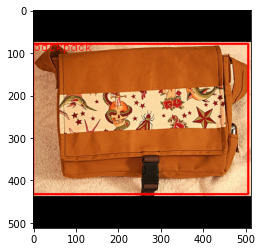

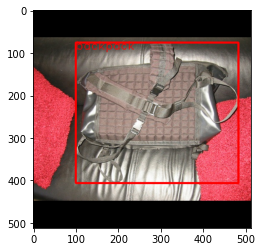

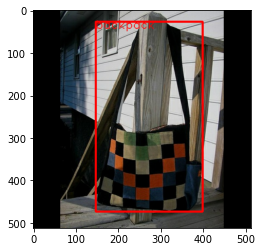

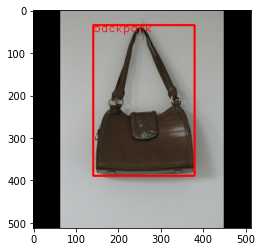

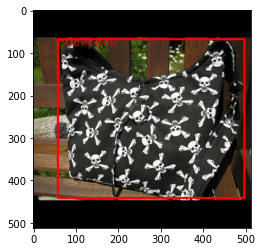

In [30]:
from random import sample
backpack_uncertain_handbag=list(backpack_uncertain['handbag'])
backpack_uncertain_xml_annot=[i+'.xml' for i in backpack_uncertain_handbag]
folder_annot=os.path.relpath('Filtered/annotations/backpack')
folder_img=os.path.relpath('Filtered/images/backpack')

misclassified_count=visualise_image_with_bbox(folder_img,folder_annot,sample(backpack_uncertain_xml_annot,5))
print(f'Sampled {misclassified_count} pictures of handbag mislabelled as backpack')

### Potentially misclassified backpack class that should be 'luggage'
 #### <a href='#toc'>^ Back to Table of Contents</a>

There are potentially 3 luggage pictures mislabelled as backpack


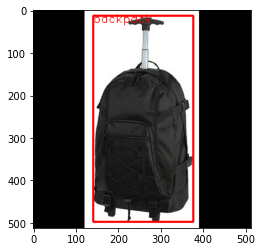

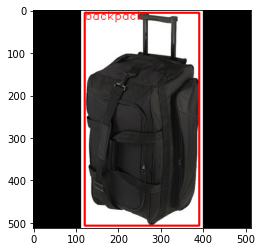

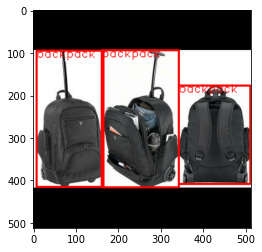

In [31]:
backpack_uncertain_luggage=list(backpack_uncertain['luggage'])
backpack_uncertain_luggage_xml_annot=[ i+'.xml' for i in backpack_uncertain_luggage]
folder_annot=os.path.relpath('Filtered/annotations/backpack')
folder_img=os.path.relpath('Filtered/images/backpack')
misclassified_count=visualise_image_with_bbox(folder_img,folder_annot,backpack_uncertain_luggage_xml_annot)
print(f'There are potentially {misclassified_count} luggage pictures mislabelled as backpack')


Questions:
- If we map folder name for images using this mapping, there could be misclassified class name as illustrated in previous codes (i.e. 'luggage' or handbag' in mapped class of 'backpack). Do we need to visually inspect for each mapped class in such case?
    - mapping_dict_name={'bag': 'backpack', 
              'n03709823': 'handbag', 
              'n04026417': 'handbag'
              ,}

Response:
> Best to find a quick way to visually verify and even better that if can find a way to fix it algorithmically

<a id='convertimgsize'></a>
## Converting image size and corresponding XML annotations

#### <a href='#toc'>^ Back to Table of Contents</a>
- Standardize all images resolution to 640 x 640


<a id='convertxml'></a>
### Converting XML annotations

#### <a href='#toc'>^ Back to Table of Contents</a>
 
- As all the image resolution will be converted to 640 x 640 for standardization of image dataset, its corresponding XML annotations will also need to be converted accordingly
    -  Converting all width and height to 640 and 640
    -  Converting the coordinates for bndbox to the appropriate value based on the scaling factor and padding information   


In [32]:
##checking xml annotation
import xml.etree.ElementTree as ElementTree

def find_width_height_depth(root):
    size=root.find('./size')
    width,height,depth=int(size[0].text),int(size[1].text),int(size[2].text)
    return width,height,depth

def folder_xml_dims(folder_name):
    subfolders=os.listdir(folder_name)
    folder_xml_dims={}
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(folder_name,subfolder)
        folder_xml_dims[subfolder]=set()
        for xml_annotation in os.listdir(path_to_subfolder):
            file=os.path.join(path_to_subfolder,xml_annotation)
            tree=ElementTree.parse(file)
            root=tree.getroot()
            dim=find_width_height_depth(root)
            folder_xml_dims[subfolder].add(dim)       
            
    return folder_xml_dims

In [33]:
folder_name=os.path.relpath('Filtered/annotations')
folder_xml_dims(folder_name)

{'backpack': {(512, 512, 3)},
 'handbag': {(74, 152, 3),
  (87, 152, 3),
  (90, 152, 3),
  (93, 152, 3),
  (96, 152, 3),
  (99, 120, 3),
  (100, 100, 3),
  (109, 143, 3),
  (110, 107, 3),
  (114, 114, 3),
  (115, 115, 3),
  (116, 120, 3),
  (118, 98, 3),
  (119, 125, 3),
  (120, 94, 3),
  (120, 100, 3),
  (120, 101, 3),
  (120, 105, 3),
  (120, 116, 3),
  (120, 119, 3),
  (120, 120, 3),
  (125, 115, 3),
  (127, 160, 3),
  (128, 90, 3),
  (128, 96, 3),
  (128, 105, 3),
  (128, 124, 3),
  (128, 128, 3),
  (130, 128, 3),
  (136, 200, 3),
  (137, 137, 3),
  (140, 92, 3),
  (140, 140, 3),
  (145, 78, 3),
  (145, 181, 3),
  (149, 149, 3),
  (150, 130, 3),
  (150, 150, 3),
  (150, 179, 3),
  (150, 196, 3),
  (150, 200, 3),
  (151, 101, 3),
  (160, 160, 3),
  (163, 216, 3),
  (168, 140, 3),
  (175, 121, 3),
  (178, 500, 3),
  (180, 150, 3),
  (182, 143, 3),
  (200, 150, 3),
  (200, 179, 3),
  (200, 182, 3),
  (200, 200, 3),
  (204, 500, 3),
  (208, 170, 3),
  (213, 276, 3),
  (215, 500, 3),
  

In [34]:
## For changing xml annotations
import xml.etree.ElementTree as ElementTree
import os
import numpy as np

def rescale(i,i_scale):
    return int(np.round(i*i_scale))

def shift(i,i_shift):
    return int(np.round(i+i_shift))

def change_bbox_coordinate(coordinate,scale_val,shift_val):
    coordinate=shift(rescale(coordinate,scale_val),shift_val)
    return coordinate

def get_image_filename(root):
    return root.find('filename').text

def get_objects(root):
    return root.findall('./object')

def get_name(object):
    for name in object.findall('./name'):
        return name.text

def replace_bbox(object,new_bbox_list):
    for item,bbox in zip(object.findall('./bndbox'),new_bbox_list):
        # convert all items in tuple to strings as xml require string format
        new_xmin,new_ymin,new_xmax,new_ymax=[str(coordinate) for coordinate in bbox]
        item[0].text,item[1].text,item[2].text,item[3].text=new_xmin,new_ymin,new_xmax,new_ymax
    return 

def find_dim(root):
    size=root.find('./size')
    old_x,old_y=int(size[0].text),int(size[1].text)
    return old_x,old_y

def replace_dim(root,new_dim):
    size=root.find('size')
    # convert all items in tuple to strings as xml require string format
    new_x,new_y=[str(i) for i in new_dim]
    size.find('width').text=new_x
    size.find('height').text=new_y
    return 

def get_new_bbox_list(object,old_dim,new_dim):
    scale=new_dim[0]/max(old_dim)
    old_x,old_y=old_dim
    new_x,new_y=new_dim
    x_shift=(new_x-(old_x*scale))/2
    y_shift=(new_y-(old_y*scale))/2
    bbox_list=[]
    for item in object.findall('./bndbox'):
        xmin,ymin,xmax,ymax=int(item[0].text),int(item[1].text),int(item[2].text),int(item[3].text)
        xmin=change_bbox_coordinate(xmin,scale,x_shift)
        ymin=change_bbox_coordinate(ymin,scale,y_shift)
        xmax=change_bbox_coordinate(xmax,scale,x_shift)
        ymax=change_bbox_coordinate(ymax,scale,y_shift)
        bbox=xmin,ymin,xmax,ymax
        bbox_list.append(bbox)
    return bbox_list

def folder_xml_convert(read_path,saved_path,new_dim):
    subfolders=os.listdir(read_path)
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(read_path,subfolder)
        
        for xml_annotation in os.listdir(path_to_subfolder):
            file=os.path.join(path_to_subfolder,xml_annotation)
            tree=ElementTree.parse(file)
            root=tree.getroot()
            old_dim=find_dim(root)       
            replace_dim(root,new_dim)
            for object in get_objects(root):
                new_bbox_list=get_new_bbox_list(object,old_dim,new_dim)
                replace_bbox(object,new_bbox_list)
            
            #used to create directory recursively, exist_ok-> if already exist leaves dir unaltered
            os.makedirs(f'{saved_path}/{subfolder}',exist_ok=True)
            tree.write(f'{saved_path}/{subfolder}/{xml_annotation}')
        print(f'Completed conversion of XML annotations on Folder {subfolder} for new specified dimensions:{new_dim}')
    return



In [35]:
read_path=os.path.relpath('Filtered/annotations')
saved_path=os.path.relpath('Filtered/annotations')
new_dim=(640,640)
folder_xml_convert(read_path,saved_path,new_dim)

Completed conversion of XML annotations on Folder backpack for new specified dimensions:(640, 640)
Completed conversion of XML annotations on Folder handbag for new specified dimensions:(640, 640)


In [36]:
folder_name=os.path.relpath('Filtered/annotations')
folder_xml_dims(folder_name)

{'backpack': {(640, 640, 3)}, 'handbag': {(640, 640, 3)}}

<a id='convertimg'></a>
### Converting image file

#### <a href='#toc'>^ Back to Table of Contents</a> 
- All the image resolution will be converted to 640 x 640 for standardization of image dataset
- Image will be resized to the target width and height by keeping the aspect ratio the same. If the target dimensions don't match the image dimensions, the image is resized and then padded  to match requested dimension  

#### Grayscale image in dataset: 
Take note that there will be grayscale image in ImageNet dataset

Shape of array:(250, 180)


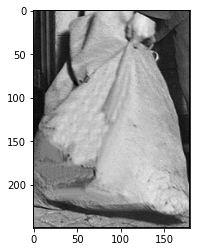

In [37]:
## example of a grayscale image
import matplotlib.pyplot as plt
path_grayscale_img_eg1=r'C:\Users\mpe_0\DA\Unattended_bag_detection\ImageNet_bags\Unfiltered\images\n03709823\n03709823_11319.JPEG'
grayscale_img_array=plt.imread(path_grayscale_img_eg1)
img_shape=grayscale_img_array.shape
print(f'Shape of array:{img_shape}')
_=plt.imshow(grayscale_img_array,cmap='gray')

#### Checking the unique image array in each folder and presence of grayscale image

In [38]:
## defining a function that return unique shape in each folder
import matplotlib.pyplot as plt

def folder_unique_shapes(folder_name):
    subfolders=os.listdir(folder_name)
    folder_image_shapes={}
    folder_grayscale_images={}
    
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(folder_name,subfolder)
        folder_image_shapes[subfolder]=set()
        folder_grayscale_images[subfolder]=set()
        for image_file in os.listdir(path_to_subfolder):
            image=os.path.join(path_to_subfolder,image_file)
            image_array=plt.imread(image)
            image_array_shape=image_array.shape
            folder_image_shapes[subfolder].add(image_array_shape)
            
            # if grayscale
            if len(image_array_shape)==2:
                folder_grayscale_images[subfolder].add(image_file)
            
    
    return folder_image_shapes,folder_grayscale_images

In [39]:
## Before conversion
## unique image array in each folder and presence of grayscale image
folder_name=os.path.relpath('Filtered/images')
folder_image_shapes,folder_grayscale_images=folder_unique_shapes(folder_name)
print('--Shapes--')
for folder,shapes_set in folder_image_shapes.items():
    print(folder,shapes_set)
print('--Unique image array shape--')
for folder,shapes_set in folder_image_shapes.items():
    print(f'Folder {folder}:{len(shapes_set)} unique image array shape')
print('--Grayscale image--')
for folder,grayscale_filename_set in folder_grayscale_images.items():
    print(f'Folder {folder}: {grayscale_filename_set}')

--Shapes--
backpack {(512, 512, 3)}
handbag {(500, 399, 3), (500, 288, 3), (346, 500), (342, 397, 3), (303, 500, 3), (500, 302, 3), (294, 377, 3), (500, 405, 3), (238, 218, 3), (500, 333, 3), (202, 270, 3), (338, 522, 3), (374, 495, 3), (415, 560, 3), (372, 393), (284, 380, 3), (387, 500, 3), (573, 430, 3), (485, 580, 3), (474, 458, 3), (410, 475, 3), (585, 439, 3), (439, 585, 3), (226, 320, 3), (316, 450, 3), (289, 395, 3), (463, 500, 3), (1030, 400, 3), (273, 440, 3), (646, 613, 3), (500, 476, 3), (432, 288, 3), (475, 466, 3), (321, 400, 3), (500, 385, 3), (473, 500, 3), (100, 100, 3), (193, 263), (558, 600, 3), (600, 492, 3), (500, 377, 3), (181, 145, 3), (435, 430, 3), (333, 333, 3), (480, 346, 3), (279, 408, 3), (385, 446, 3), (338, 350, 3), (318, 500, 3), (520, 520, 3), (320, 240, 3), (986, 722, 3), (616, 821, 3), (242, 320, 3), (423, 333, 3), (143, 182, 3), (450, 450, 3), (500, 456, 3), (220, 250, 3), (482, 349, 3), (285, 380, 3), (500, 445, 3), (285, 285, 3), (500, 470, 3), (50

#### Function to convert image
- To account for grayscale image, there is a need to perform manipulation since tf.image.resize_with_pad takes in 3d tensor. 
- Please refer to the stackoverflow question [here](https://stackoverflow.com/questions/51872412/tensorflow-numpy-image-reshape-grayscale-images) for more details

In [41]:
##Function to convert image to new dimension and saved it to desired path
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def folder_img_convert(read_path,saved_path,new_dim):
    new_y,new_x=new_dim
    subfolders=os.listdir(read_path)
    for subfolder in subfolders:
        path_to_subfolder=os.path.join(read_path,subfolder)
        for image_file in os.listdir(path_to_subfolder):
            image=os.path.join(path_to_subfolder,image_file)
            image_array=plt.imread(image)
            ##check if grayscale or colored
            arr_shape=len(image_array.shape)
            ## if grayscale
            if arr_shape==2:
                # if grayscale, need to add last dimensions as tf.image.resize_with_pad takes in 3d tensor
                last_axis=-1
                image_array=np.expand_dims(image_array,last_axis)
                dim_to_repeat=2
                repeats=3
                image_array=np.repeat(image_array,repeats,dim_to_repeat)
            
            image_array_resized=tf.image.resize_with_pad(image_array,new_y,new_x)
            image_array_resized=tf.cast(image_array_resized,tf.uint8)
            image_array_resized=image_array_resized.numpy()
            
            #used to create directory recursively, exist_ok-> if already exist leaves dir unaltered
            os.makedirs(f'{saved_path}/{subfolder}',exist_ok=True)
            plt.imsave(f'{saved_path}/{subfolder}/{image_file}',image_array_resized)
        print(f'Completed conversion of images on Folder {subfolder} for new specified dimensions:{new_dim}')
    return
            

C:\Users\mpe_0\miniconda3\envs\torch\lib\site-packages\requests\__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [42]:
# converting image from Filtered/images and replacing it (inplace operation)
read_path=os.path.relpath('Filtered/images')
saved_path=os.path.relpath('Filtered/images')
new_dim=(640,640)
folder_img_convert(read_path,saved_path,new_dim)

Completed conversion of images on Folder backpack for new specified dimensions:(640, 640)
Completed conversion of images on Folder handbag for new specified dimensions:(640, 640)


In [43]:
## After conversion
## unique image array in each folder and presence of grayscale image

folder_name=os.path.relpath('Filtered/images')
folder_image_shapes,folder_grayscale_images=folder_unique_shapes(folder_name)
print('--Shapes--')
for folder,shapes_set in folder_image_shapes.items():
    print(folder,shapes_set)
print('--Unique image array shape--')
for folder,shapes_set in folder_image_shapes.items():
    print(f'Folder {folder}:{len(shapes_set)} unique image array shape')
print('--Grayscale image--')
for folder,grayscale_filename_set in folder_grayscale_images.items():
    print(f'Folder {folder}: {grayscale_filename_set}')

--Shapes--
backpack {(640, 640, 3)}
handbag {(640, 640, 3)}
--Unique image array shape--
Folder backpack:1 unique image array shape
Folder handbag:1 unique image array shape
--Grayscale image--
Folder backpack: set()
Folder handbag: set()


<a id='visualimgbbox'></a>
## Visualising image and bounding box
#### <a href='#toc'>^ Back to Table of Contents</a>


In [1]:
## Visualizing image and annotations
import xml.etree.ElementTree as ElementTree
import os
import matplotlib.pyplot as plt
import cv2
import re
from random import sample

def get_image_filename(root):
    return root.find('filename').text

def get_objects(root):
    return root.findall('./object')

def get_name(object):
    for name in object.findall('./name'):
        return name.text

def get_bbox(object):
    for item in object.findall('./bndbox'):
        xmin,ymin,xmax,ymax=item[0].text,item[1].text,item[2].text,item[3].text
    return xmin,ymin,xmax,ymax

def visualise(image,name,folder_img,bboxes):
    """Visualise a given image in a folder and its corresponding bounding boxes

    Args:
        image ([str]): filename
        name ([str]): name of the annotation box(es)
        folder_img ([str]): folder name containing the image(s)
        bboxes ([list]): list containing 4 tuples (xmin,xmax,ymin,ymax)

    Returns:
        axes_image[matplotlib.image.AxesImage]: matplotlib axes image showing the image and its corresponding bounding box
    """    ''''''
    ## standardize all images to have file extension to be .jpg previously and remove all file extension from xml annot earlier
    image_file=f'{image}.jpg'
    image_array=cv2.imread(os.path.join(folder_img,image_file))
    
    color=(0,0,255)
    thickness=2
    # get matplotlib object to return plot for all in the for loop
    _,ax=plt.subplots()
    for bbox in bboxes:
        bbox = list(map(int, bbox))
        start=(bbox[0],bbox[1])

        end=(bbox[2],bbox[3])

        cv2.rectangle(image_array,start,end,color,thickness)
        cv2.putText(image_array,name,(bbox[0]+8,bbox[1]+22),cv2.FONT_HERSHEY_DUPLEX,0.9,color)
    
    axes_image=ax.imshow(cv2.cvtColor(image_array,cv2.COLOR_BGR2RGB))
    return axes_image

def visualise_folder_image_annotation(folder_img,folder_annot,sample_size=None):
    ''' 
    folder_img:path to image folder
    folder_annot:path to annotation folder
    sample_size (int): Optional; if not indicated, will visualise whole folder, if indicated, visualised sample_size

    '''
    
    files_annot=os.listdir(folder_annot)
    # if user indicated sample_size then sample the appropriate value
    if sample_size:
        files_annot=sample(files_annot,sample_size)
    for xml_annotation in files_annot:
        if xml_annotation.endswith('.xml'):
            file=os.path.join(folder_annot,xml_annotation)
            tree=ElementTree.parse(file)
            root=tree.getroot()
            image=get_image_filename(root)

            bboxes=[]
            for object in get_objects(root):
                name=get_name(object)

                bboxes.append(get_bbox(object))
            visualise(image,name,folder_img,bboxes)
    return 

C:\Users\mpe_0\miniconda3\envs\torch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mpe_0\miniconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\mpe_0\miniconda3\envs\torch\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


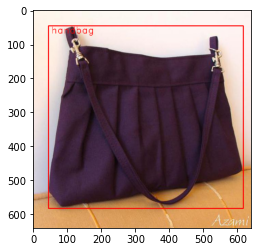

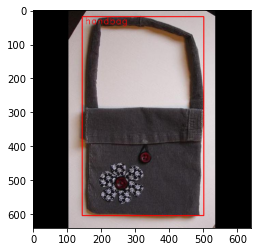

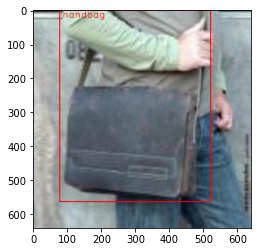

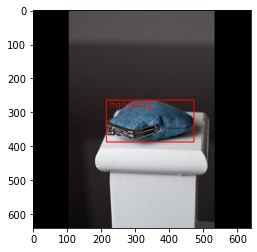

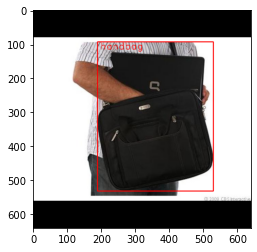

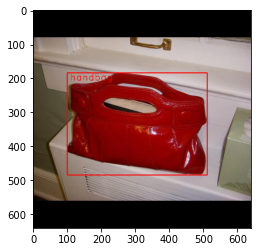

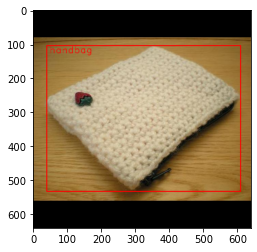

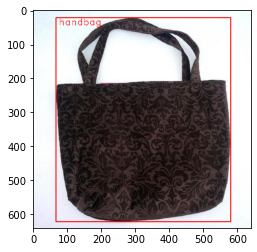

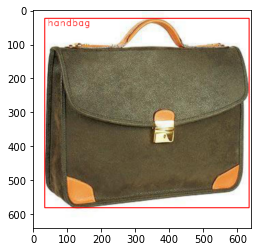

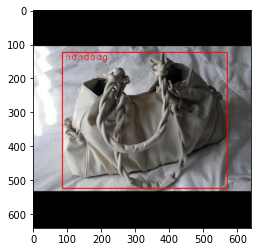

In [2]:
folder_annot=os.path.relpath('Filtered/annotations/handbag')
folder_img=os.path.relpath('Filtered/images/handbag')
visualise_folder_image_annotation(folder_img,folder_annot,sample_size=10)

Questions
- If padding for image is white, do we still pad it with black?
- Grayscale image we change it to 640 x 640 x 3

Response:
- You can have white and black padding in a image
- grayscale image can just change to 640 x 640 x 3. Then it was found that the depth of the xml annotation for grayscale image is 3 despite it being a grayscale image. So ignore the conversion of xml annotation for grayscale image

<a id='model_generate_annot'></a>
## Using trained model to generate missing annotations

 #### <a href='#toc'>^ Back to Table of Contents</a>
- As seen previously, there are missing annotations for some images of handbags (1645) and missing annotations for humans. In this section, will use a pretrained model for generate annotation

In [1]:
import os

def get_files_names_with_extension(full_path, format):
    ''' Function returns all files for the paricular format
    '''
    if format=='image':
        exts=('.JPEG','jpeg','.jpg','.tif','.tiff','.bmp','.gif','.png','.raw')
    elif format=='xml':
        exts='xml'
    else:
        raise Exception('Please input either "image" or "xml" for format argument')
    
    return [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f)) and f.endswith(exts)]


def find_images_with_missing_annot(folder_img,folder_annot):
    subfolders=os.listdir(folder_annot)
    missing_annot_dict={}
    
    for subfolder in subfolders:
        missing_annot_dict[subfolder]=set()
        path_to_subfolder_img=os.path.join(folder_img,subfolder)
        path_to_subfolder_annot=os.path.join(folder_annot,subfolder)
        images =  set([f.split('.')[0] for f in get_files_names_with_extension(path_to_subfolder_img,format='image')])
        annotations = set([f.split(".")[0] for f in get_files_names_with_extension(path_to_subfolder_annot, "xml")])
        diff=images.difference(annotations)
        missing_annot_dict[subfolder]=diff
    
    return missing_annot_dict


In [11]:
folder_img = 'Filtered/images'
folder_annot ='Filtered/annotations'
missing_annot_dict=find_images_with_missing_annot(folder_img,folder_annot)
for folder,missing_annot_set in missing_annot_dict.items():
    print (f'Folder {folder} has {len(missing_annot_set)} images with missing annotations')


Folder backpack has 0 images with missing annotations
Folder handbag has 1645 images with missing annotations


In [15]:
## copying files with missing annot to a separate folder
import shutil
folder_img = 'Filtered/images'
folder_annot ='Filtered/annotations'
folder_missing_annot=r'Missing_Annotations/'
missing_annot_dict=find_images_with_missing_annot(folder_img,folder_annot)

for folder,missing_annot_set in missing_annot_dict.items():
    saved_path=os.path.join(folder_missing_annot,folder)
    for missing_annot_img in missing_annot_set:
        copy_path=f'{os.path.join(folder_img,folder,missing_annot_img)}.jpg'
        print(copy_path)        
        os.makedirs(saved_path,exist_ok=True)
        try:
            shutil.copy(copy_path,saved_path)
            print(f"{missing_annot_img} copied successfully to folder {saved_path}")
        # If source and destination are same
        except shutil.SameFileError:
            print("Source and destination represents the same file.")


Filtered/images\handbag\n04026417_8949.jpg
n04026417_8949 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n04026417_31138.jpg
n04026417_31138 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n04026417_15913.jpg
n04026417_15913 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n03709823_16989.jpg
n03709823_16989 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n03709823_17737.jpg
n03709823_17737 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n04026417_6557.jpg
n04026417_6557 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n04026417_10071.jpg
n04026417_10071 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n03709823_9164.jpg
n03709823_9164 copied successfully to folder Missing_Annotations/handbag
Filtered/images\handbag\n03709823_24063.jpg
n03709823_24063 co